# Realtor.com Data Analysis
This is quick script to visualize some of the key metrics of the housing market that realtor.com compiles and provides for free on their website. Data is at the state and month level. The script should pull in the most up top date data and defaults to using the most recent complete month when reporting on year over year and month over month trends.

Metrics:
* Number of new listings (new supply)
* NUmber of active listings (total supply)
* Number of listings that went into pending 
* Median number of days on market (precursor to price increases/reductions)
* Median list price
* Number of price increases
* Number of price reductions


In [12]:
import numpy as np
import pandas as pd
import datetime
import seaborn as sns
import plotly.express as px 
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime
from my_functions import *
pd.set_option('display.max_columns', 500)

## Dataset import and prep
Note: As of fall 2022 this CSV link updates monthly to contain the most rcent data, i.e. you shouldnt have to go to the website and grab a new url each time you want to run the report, hooray!

In [24]:
realtor_data_raw = pd.read_csv("https://econdata.s3-us-west-2.amazonaws.com/Reports/Core/RDC_Inventory_Core_Metrics_State_History.csv")

# Dropping the final row because iot contains a note
realtor_data = realtor_data_raw.drop(realtor_data_raw.tail(1).index)

df = (realtor_data
    .drop(labels = ['state'], axis = 1)
    .assign(month_date_yyyymm = (realtor_data['month_date_yyyymm'] + "01").astype('datetime64'))
    .rename(columns = {'month_date_yyyymm':'month','state_id':'state'})
    .astype({'state':'category'})
    .sort_values(by = ['state','month'], ascending = True)
    )

print("Latest month of data:", df['month'].max())

Latest month of data: 2022-11-01 00:00:00


In [25]:
df.columns

Index(['month', 'state', 'median_listing_price', 'median_listing_price_mm',
       'median_listing_price_yy', 'active_listing_count',
       'active_listing_count_mm', 'active_listing_count_yy',
       'median_days_on_market', 'median_days_on_market_mm',
       'median_days_on_market_yy', 'new_listing_count', 'new_listing_count_mm',
       'new_listing_count_yy', 'price_increased_count',
       'price_increased_count_mm', 'price_increased_count_yy',
       'price_reduced_count', 'price_reduced_count_mm',
       'price_reduced_count_yy', 'pending_listing_count',
       'pending_listing_count_mm', 'pending_listing_count_yy',
       'median_listing_price_per_square_foot',
       'median_listing_price_per_square_foot_mm',
       'median_listing_price_per_square_foot_yy', 'median_square_feet',
       'median_square_feet_mm', 'median_square_feet_yy',
       'average_listing_price', 'average_listing_price_mm',
       'average_listing_price_yy', 'total_listing_count',
       'total_listing_cou

In [26]:
cols = ['month', 'state',
       'median_listing_price',
       #'median_listing_price_mm', 'median_listing_price_yy',
       'active_listing_count', #'active_listing_count_mm',
       #'active_listing_count_yy', 
       'median_days_on_market',
       #'median_days_on_market_mm', 'median_days_on_market_yy',
       'new_listing_count', 
       #'new_listing_count_mm', 'new_listing_count_yy',
       'price_increased_count', 
       #'price_increased_count_mm','price_increased_count_yy', 
       'price_reduced_count',
       #'price_reduced_count_mm', 'price_reduced_count_yy',
       'pending_listing_count', 
       #'pending_listing_count_mm', 'pending_listing_count_yy',
       #'median_listing_price_per_square_foot',
       #'median_listing_price_per_square_foot_mm','median_listing_price_per_square_foot_yy', 
       'median_square_feet',
       #'median_square_feet_mm', 'median_square_feet_yy',
       'average_listing_price', 
       #'average_listing_price_mm', 'average_listing_price_yy', 
       # 'total_listing_count',
       #'total_listing_count_mm', 'total_listing_count_yy', 'pending_ratio',
       #'pending_ratio_mm', 'pending_ratio_yy', 'quality_flag'
       ]

df = df[cols]

In [27]:
df = df.rename(columns = {'median_listing_price':'med_lp',
                          'active_listing_count':'active_listings',
                          'median_days_on_market':'med_dom',
                          'new_listing_count':'new_listings',
                          'price_increased_count':'price_increases',
                          'price_reduced_count':'price_reductions',
                          'pending_listing_count':'pending_listings',
                          'median_square_feet':'med_sf',
                          'average_listing_price':'avg_lp'})



In [28]:
# Month number and year columns, useful for time series plots
df = df.assign(
        month_num = lambda x: x.month.dt.month,
        year = lambda x: x.month.dt.year)

def get_pct_change(column, periods):
    return(df.groupby('state')[column].transform(lambda x: x.pct_change(periods = periods)*100))


# percent change year over year
df['pct_ch_med_list_1y'] = get_pct_change('med_lp', periods = 12)
df['pct_ch_active_list_1y'] = get_pct_change('active_listings', periods = 12)
df['pct_ch_med_dom_1y'] = get_pct_change('med_dom', periods = 12)
df['pct_ch_new_list_1y'] = get_pct_change('new_listings', periods = 12)
df['pct_ch_price_inc_1y'] = get_pct_change('price_increases', periods = 12)
df['pct_ch_price_red_1y'] = get_pct_change('price_reductions', periods = 12)
df['pct_ch_pending_1y'] = get_pct_change('pending_listings', periods = 12)

# percent change month over month
df['pct_ch_med_list_1m'] = get_pct_change('med_lp', periods = 1)
df['pct_ch_active_list_1m'] = get_pct_change('active_listings', periods = 1)
df['pct_ch_med_dom_1m'] = get_pct_change('med_dom', periods = 1)
df['pct_ch_new_list_1m'] = get_pct_change('new_listings', periods = 1)
df['pct_ch_price_inc_1m'] = get_pct_change('price_increases', periods = 1)
df['pct_ch_price_red_1m'] = get_pct_change('price_reductions', periods = 1)
df['pct_ch_pending_1m'] = get_pct_change('pending_listings', periods = 1)


df.tail()


,month,state,med_lp,active_listings,med_dom,new_listings,price_increases,price_reductions,pending_listings,med_sf,avg_lp,month_num,year,pct_ch_med_list_1y,pct_ch_active_list_1y,pct_ch_med_dom_1y,pct_ch_new_list_1y,pct_ch_price_inc_1y,pct_ch_price_red_1y,pct_ch_pending_1y,pct_ch_med_list_1m,pct_ch_active_list_1m,pct_ch_med_dom_1m,pct_ch_new_list_1m,pct_ch_price_inc_1m,pct_ch_price_red_1m,pct_ch_pending_1m
243,2022-07-01,WY,439900.0,1848.0,37.0,1112.0,12.0,572.0,721.0,2287.0,963362.0,7,2022,35.981453,10.857828,-5.128205,-2.797203,-62.500000,83.333333,-26.127049,7.292683,26.315789,15.625000,-5.119454,-33.333333,31.797235,-5.504587
162,2022-08-01,WY,449450.0,2018.0,48.0,1036.0,18.0,666.0,708.0,2336.0,989271.0,8,2022,37.257597,17.462165,6.666667,-1.893939,-18.181818,64.039409,-29.129129,2.170948,9.199134,29.729730,-6.834532,50.000000,16.433566,-1.803051
106,2022-09-01,WY,430000.0,2035.0,54.0,958.0,14.0,606.0,678.0,2326.0,1000097.0,9,2022,30.303030,19.776339,8.000000,4.585153,-36.363636,58.638743,-31.859296,-4.327511,0.842418,12.500000,-7.528958,-22.222222,-9.009009,-4.237288
97,2022-10-01,WY,430000.0,1929.0,61.0,728.0,16.0,496.0,556.0,2328.0,995430.0,10,2022,32.307692,24.692954,12.962963,-14.953271,-50.000000,51.219512,-40.534759,0.000000,-5.208845,12.962963,-24.008351,14.285714,-18.151815,-17.994100
1,2022-11-01,WY,428450.0,1897.0,71.0,600.0,10.0,398.0,402.0,2351.0,917251.0,11,2022,34.966136,34.825871,14.516129,-8.814590,-58.333333,80.909091,-51.331719,-0.360465,-1.658891,16.393443,-17.582418,-37.500000,-19.758065,-27.697842


## Summary of Key Metrics

In [31]:
def get_obs(column):
    return(np.round(df.query("month == @analysis_month").loc[:, column].mean(),2))


current_month = datetime.now().month -1
current_year = datetime.now().year

analysis_month = str(current_year)+'-'+str(current_month) + '-'+'01'
print("The following analysis will be in relation to:", analysis_month)

The following analysis will be in relation to: 2022-11-01


#### What is happening with housing supply?

In [32]:
a = get_obs(column = 'pct_ch_active_list_1y')
b = get_obs(column = 'pct_ch_active_list_1m')

c = get_obs(column = 'pct_ch_new_list_1y')
d = get_obs(column = 'pct_ch_new_list_1m')

print("For the month of ", analysis_month, ":")
print(" ")
print("The average number of active listings has changed by", a, "% year over year and by", b, "% month over month")
print("------------------------")
print("The average number of new listings has changed by", c, "% year over year and by", d, "% month over month")

For the month of  2022-11-01 :
 
The average number of active listings has changed by 42.3 % year over year and by -1.15 % month over month
------------------------
The average number of new listings has changed by -17.14 % year over year and by -18.83 % month over month


### Whats happening to the number of houses getting sold? How long are listings staying on market?

In [33]:
a = get_obs(column = 'pct_ch_pending_1y')
b = get_obs(column = 'pct_ch_pending_1m')

c = get_obs(column = 'pct_ch_med_dom_1y')
d = get_obs(column = 'pct_ch_med_dom_1m')

print("For the month of ", analysis_month, ":")
print(" ")
print("The average number of pending listings has changed by", a, "% year over year and by", b, "% month over month")
print("------------------------")
print("The average change for the median days on market across states is", c, "% year over year and by", d, "% month over month")

For the month of  2022-11-01 :
 
The average number of pending listings has changed by -35.91 % year over year and by -12.77 % month over month
------------------------
The average change for the median days on market across states is 13.78 % year over year and by 9.94 % month over month


### What is happening to housing prices?

In [34]:
a = get_obs(column = 'pct_ch_med_list_1y')
b = get_obs(column = 'pct_ch_med_list_1m')

c = get_obs(column = 'pct_ch_price_inc_1y')
d = get_obs(column = 'pct_ch_price_inc_1m')

e = get_obs(column = 'pct_ch_price_red_1y')
f =get_obs(column = 'pct_ch_price_red_1m')

print("For the month of ", analysis_month, ":")
print(" ")
print("The average change for the median list price across states is", a, "% year over year and by", b, "% month over month")
print("------------------------")
print("The average number of price increases has changed by", c, "% year over year and by", d, "% month over month")
print("------------------------")
print("The average number of price reductions has changed by", e, "% year over year and by", f, "% month over month")

For the month of  2022-11-01 :
 
The average change for the median list price across states is 13.68 % year over year and by -1.05 % month over month
------------------------
The average number of price increases has changed by -44.38 % year over year and by -15.91 % month over month
------------------------
The average number of price reductions has changed by 93.34 % year over year and by -14.44 % month over month


### Snapshot of year over year results in more detail

In [35]:
(df.query("month ==@analysis_month")
.loc[:,df.columns.str.endswith('1y')]
.describe()
.T)

,count,mean,std,min,25%,50%,75%,max
pct_ch_med_list_1y,51.0,13.676007,8.658305,-0.377750,7.792633,12.705882,18.146085,34.966136
pct_ch_active_list_1y,51.0,42.300322,38.498690,-8.934828,14.818879,34.825871,64.695601,166.641902
pct_ch_med_dom_1y,51.0,13.775339,20.723302,-11.392405,2.152778,7.272727,20.731707,80.555556
pct_ch_new_list_1y,51.0,-17.138019,7.066802,-39.941176,-21.459670,-17.591275,-13.076375,-3.338898
pct_ch_price_inc_1y,51.0,-44.382399,31.143932,-93.622921,-61.898707,-52.777778,-35.725956,100.000000
pct_ch_price_red_1y,51.0,93.337626,65.999128,10.344828,37.019651,74.380750,140.323639,249.104983
pct_ch_pending_1y,51.0,-35.906161,8.558545,-51.331719,-41.360359,-36.392206,-32.682193,-7.768980


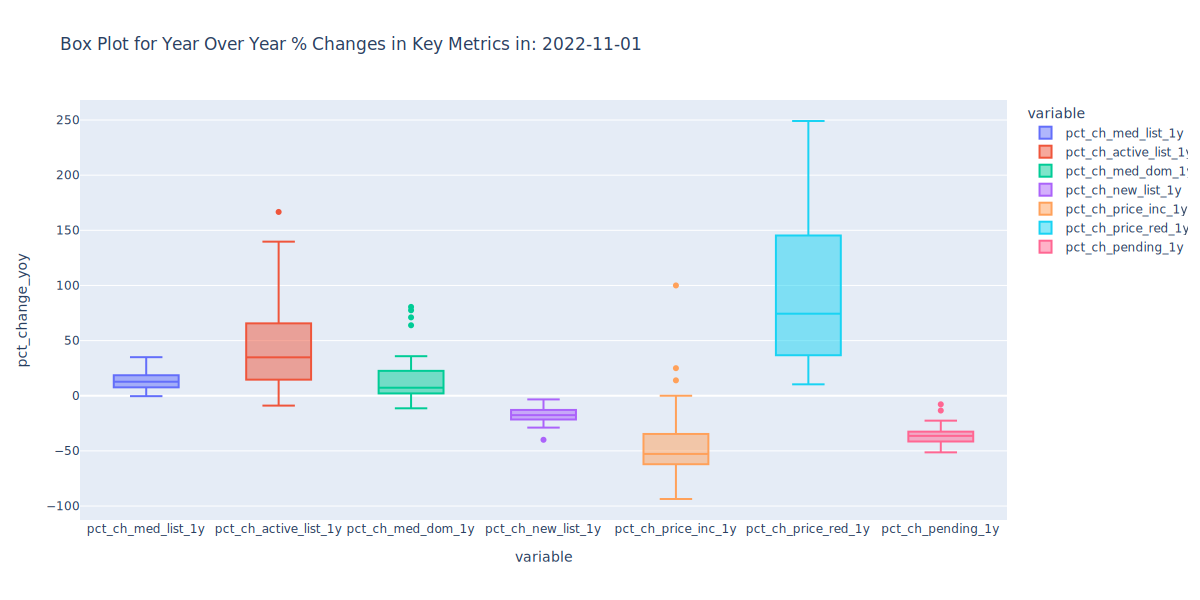

In [39]:
px.box(df.query("month == @analysis_month")
        .loc[:,df.columns.str.endswith('1y')]
        .melt(value_name = 'pct_change_yoy'),
        x= 'variable',
        y = 'pct_change_yoy',
        color = 'variable',
        height= 600,
        width = 1200,
        title = "Box Plot for Year Over Year % Changes in Key Metrics in: " + analysis_month).show(renderer = 'svg')

### Snapshot of month over month results in more detail

In [37]:
(df.query("month == @analysis_month")
    .loc[:,df.columns.str.endswith('1m')]
    .describe()
    .T)

,count,mean,std,min,25%,50%,75%,max
pct_ch_med_list_1m,51.0,-1.051363,1.345658,-4.699887,-1.689237,-1.205357,-0.020040,1.615646
pct_ch_active_list_1m,51.0,-1.154069,4.035784,-8.452009,-4.283880,-1.499110,2.426925,6.273050
pct_ch_med_dom_1m,51.0,9.941900,5.648486,-1.666667,6.878203,9.259259,11.848436,33.333333
pct_ch_new_list_1m,51.0,-18.833100,7.105980,-32.352941,-23.936508,-18.590832,-14.377831,-0.432277
pct_ch_price_inc_1m,51.0,-15.912863,27.325504,-66.666667,-31.634615,-17.469880,-3.635070,91.176471
pct_ch_price_red_1m,51.0,-14.435782,9.663684,-39.977221,-21.363987,-13.993849,-6.790638,5.038258
pct_ch_pending_1m,51.0,-12.767868,4.549916,-27.697842,-15.501081,-11.850971,-9.997929,-3.823134


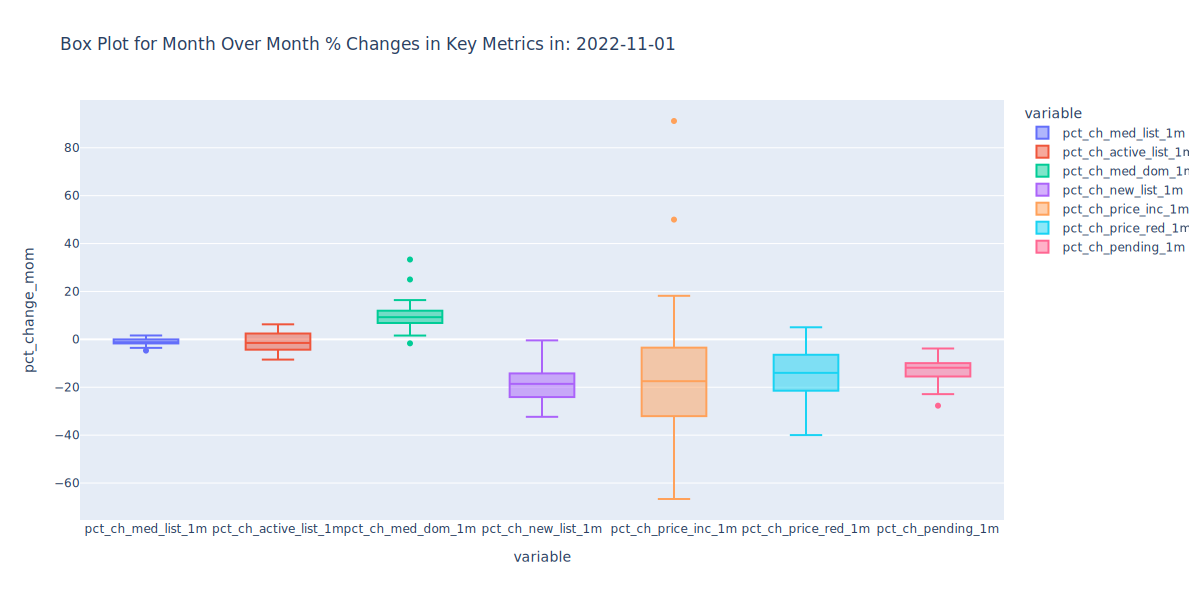

In [38]:
px.box(df.query("month == @analysis_month")
        .loc[:,df.columns.str.endswith('1m')]
        .melt(value_name = 'pct_change_mom'),
        x= 'variable',
        y = 'pct_change_mom',
        color = 'variable',
        height= 600,
        width = 1200,
        title = "Box Plot for Month Over Month % Changes in Key Metrics in: " + analysis_month).show(renderer = 'svg')

## Visualizing key metrics by State

In [40]:
select_states = ['NE','KA','WY','CA','OR','PA','CO','IL','WI','UT','ID','MI','NY']
select_states

['NE', 'KA', 'WY', 'CA', 'OR', 'PA', 'CO', 'IL', 'WI', 'UT', 'ID', 'MI', 'NY']

### Number of active listings ( total supply)

In [42]:
fig = px.line(df.query("state in @select_states"),
    x = 'month_num',
    y = 'active_listings',
    color = 'year',
    facet_col = 'state',
    facet_col_wrap = 4,
    title = 'Active Listings over Time by State',
    color_discrete_sequence=px.colors.sequential.Inferno
    )
fig.update_yaxes(matches = None)
fig.update_layout(height = 800, width = 1200)
fig.show()#(renderer = 'svg')

### Number of listings that had a status of 'pending' during the month 

In [43]:
fig = px.line(df.query("state in @select_states"),
    x = 'month_num',
    y = 'pending_listings',
    color = 'year',
    facet_col = 'state',
    facet_col_wrap = 4,
    title = 'Pending Listings over Time by State',
    color_discrete_sequence=px.colors.sequential.Inferno
    )
fig.update_yaxes(matches = None)
fig.update_layout(height = 800, width = 1200)
fig.show()#(renderer = 'svg')

### Median number of days listings remain on the market 

In [44]:
fig = px.line(df.query("state in @select_states"),
    x = 'month_num',
    y = 'med_dom',
    color = 'year',
    facet_col = 'state',
    facet_col_wrap = 4,
    title = 'Median Days on Market over Time by State',
    color_discrete_sequence=px.colors.sequential.Inferno
    )
fig.update_yaxes(matches = None)
fig.update_layout(height = 800, width = 1200)
fig.show()#(renderer = 'svg')

### Median List Prices

In [45]:
fig = px.line(df.query("state in @select_states"),
    x = 'month_num',
    y = 'med_lp',
    color = 'year',
    facet_col = 'state',
    facet_col_wrap = 4,
    title = 'Median List Prices of Homes Over Time by State',
    color_discrete_sequence=px.colors.sequential.Inferno
    )
fig.update_yaxes(matches = None)
fig.update_layout(height = 800, width = 1200)
fig.show()#(renderer = 'svg')

### Number of listed properties with price reductions 

In [72]:
fig = px.line(df.query("state in @select_states"),
    x = 'month_num',
    y = 'price_reductions',
    color = 'year',
    facet_col = 'state',
    facet_col_wrap = 4,
    title = 'Price Reductions Over Time by State',
    color_discrete_sequence=px.colors.sequential.Inferno
    )
fig.update_yaxes(matches = None)
fig.update_layout(height = 800, width = 1200)
fig.show()#(renderer = 'svg')

### State by state look at key metrics

In [61]:
states = ['CA','CO','ID','IL']

for i in states:
        st = (df.query("state ==@i")
        .loc[:,('month','month_num','year','active_listings','pending_listings','med_dom','price_reductions')]
        )

        quad_yaxis_plot(x = st.month, 
                        y1 = st.active_listings, 
                        y2 = st.pending_listings,
                        y3 = st.med_dom, 
                        y4 = st.price_reductions,
                        plot_title = i + ': Four key metrics over time', 
                        x_title = 'month', 
                        y1_title = 'Active Listings', 
                        y2_title = 'Pending Listings', 
                        y3_title = 'Median Days on Market', 
                        y4_title = 'Price Reductions').show()#(renderer = 'svg')

In [83]:
df.tail()

,month,state,med_lp,active_listings,med_dom,new_listings,price_increases,price_reductions,pending_listings,med_sf,avg_lp,month_num,year,pct_ch_med_list_1y,pct_ch_active_list_1y,pct_ch_med_dom_1y,pct_ch_new_list_1y,pct_ch_price_inc_1y,pct_ch_price_red_1y,pct_ch_pending_1y,pct_ch_med_list_1m,pct_ch_active_list_1m,pct_ch_med_dom_1m,pct_ch_new_list_1m,pct_ch_price_inc_1m,pct_ch_price_red_1m,pct_ch_pending_1m,pct_ch_price_red_1m_lag1
243,2022-07-01,WY,439900.0,1848.0,37.0,1112.0,12.0,572.0,721.0,2287.0,963362.0,7,2022,35.981453,10.857828,-5.128205,-2.797203,-62.500000,83.333333,-26.127049,7.292683,26.315789,15.625000,-5.119454,-33.333333,31.797235,-5.504587,16.433566
162,2022-08-01,WY,449450.0,2018.0,48.0,1036.0,18.0,666.0,708.0,2336.0,989271.0,8,2022,37.257597,17.462165,6.666667,-1.893939,-18.181818,64.039409,-29.129129,2.170948,9.199134,29.729730,-6.834532,50.000000,16.433566,-1.803051,-9.009009
106,2022-09-01,WY,430000.0,2035.0,54.0,958.0,14.0,606.0,678.0,2326.0,1000097.0,9,2022,30.303030,19.776339,8.000000,4.585153,-36.363636,58.638743,-31.859296,-4.327511,0.842418,12.500000,-7.528958,-22.222222,-9.009009,-4.237288,-18.151815
97,2022-10-01,WY,430000.0,1929.0,61.0,728.0,16.0,496.0,556.0,2328.0,995430.0,10,2022,32.307692,24.692954,12.962963,-14.953271,-50.000000,51.219512,-40.534759,0.000000,-5.208845,12.962963,-24.008351,14.285714,-18.151815,-17.994100,-19.758065
1,2022-11-01,WY,428450.0,1897.0,71.0,600.0,10.0,398.0,402.0,2351.0,917251.0,11,2022,34.966136,34.825871,14.516129,-8.814590,-58.333333,80.909091,-51.331719,-0.360465,-1.658891,16.393443,-17.582418,-37.500000,-19.758065,-27.697842,NaN


In [68]:
df['pct_ch_price_red_1m_lag1'] = df.groupby('state')['pct_ch_price_red_1m'].shift(periods = -1)
df[['month','state','pct_ch_med_dom_1m','pct_ch_price_red_1m','pct_ch_price_red_1m_lag1']].tail()

,month,state,pct_ch_med_dom_1m,pct_ch_price_red_1m,pct_ch_price_red_1m_lag1
243,2022-07-01,WY,15.625000,31.797235,16.433566
162,2022-08-01,WY,29.729730,16.433566,-9.009009
106,2022-09-01,WY,12.500000,-9.009009,-18.151815
97,2022-10-01,WY,12.962963,-18.151815,-19.758065
1,2022-11-01,WY,16.393443,-19.758065,NaN


In [70]:
px.scatter(df, 
            x = 'pct_ch_med_dom_1m',
            y = 'pct_ch_price_red_1m_lag1', 
            color = 'state',
            height = 800, 
            width = 1000,
            hover_data= ['state', 'month'],
            trendline= 'ols',
            title = "Relationship between change in median d.o.m. and the number of price reductions in the following month" ).show()

# Which states are seeing the biggest changes year over year?

In [89]:
df.columns

Index(['month', 'state', 'med_lp', 'active_listings', 'med_dom',
       'new_listings', 'price_increases', 'price_reductions',
       'pending_listings', 'med_sf', 'avg_lp', 'month_num', 'year',
       'pct_ch_med_list_1y', 'pct_ch_active_list_1y', 'pct_ch_med_dom_1y',
       'pct_ch_new_list_1y', 'pct_ch_price_inc_1y', 'pct_ch_price_red_1y',
       'pct_ch_pending_1y', 'pct_ch_med_list_1m', 'pct_ch_active_list_1m',
       'pct_ch_med_dom_1m', 'pct_ch_new_list_1m', 'pct_ch_price_inc_1m',
       'pct_ch_price_red_1m', 'pct_ch_pending_1m', 'pct_ch_price_red_1m_lag1'],
      dtype='object')

In [88]:
px.bar(df.query("month == '2022-11-01'"),
         x = 'state', 
         y = 'pct_ch_active_list_1y',
         color = 'pct_ch_active_list_1y',
         title = 'Year over year changes in the volume of active listings').show()

In [91]:
px.bar(df.query("month == '2022-11-01'"),
         x = 'state', 
         y = 'pct_ch_med_list_1y',
         color = 'pct_ch_med_list_1y',
         title = 'Year over year changes in median listing prices').show()

In [86]:
px.bar(df.query("month == '2022-11-01'"),
         x = 'state', 
         y = 'pct_ch_price_red_1y',
         color = 'pct_ch_price_red_1y',
         title = 'Year over year changes in the volume of price reductions').show()

#  Metropolitan Area Analysis

In [130]:
metro_data_raw = pd.read_csv("https://econdata.s3-us-west-2.amazonaws.com/Reports/Core/RDC_Inventory_Core_Metrics_Metro_History.csv")

C:\Users\parke\AppData\Local\Temp\ipykernel_21572\3819156969.py:1: DtypeWarning:

Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.



In [138]:
metro_data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71380 entries, 0 to 71379
Data columns (total 41 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   month_date_yyyymm                        71380 non-null  object 
 1   cbsa_code                                71380 non-null  object 
 2   cbsa_title                               71379 non-null  object 
 3   HouseholdRank                            71379 non-null  float64
 4   median_listing_price                     71379 non-null  float64
 5   median_listing_price_mm                  60255 non-null  float64
 6   median_listing_price_yy                  60255 non-null  float64
 7   active_listing_count                     71379 non-null  float64
 8   active_listing_count_mm                  60254 non-null  float64
 9   active_listing_count_yy                  60254 non-null  float64
 10  median_days_on_market                    71379

In [150]:
pd.to_datetime(metro_data_raw['month_date_yyyymm'].astype(str) + "01")

ParserError: Unknown string format: quality_flag = 1:  year-over-year figures may be impacted01

In [198]:
# for some reason the final row was corrupt with a note

metro = (metro_data_raw
            .drop(index = metro_data_raw.tail(1).index)      # final row contains a note that must be removed
            .assign(month_date_yyyymm = (metro_data_raw['month_date_yyyymm'].astype(str) + '01'),
                    state = metro_data_raw['cbsa_title'].str.rsplit(',').str[-1].str.strip())
            .rename(columns = {'month_date_yyyymm':'month','cbsa_title':'title'})
            .astype({'title':'category','month':'datetime64','state':'category'})
            .sort_values(by = ['month','state','title'], ascending = True)
        )

metro.head()

,month,cbsa_code,title,HouseholdRank,median_listing_price,median_listing_price_mm,median_listing_price_yy,active_listing_count,active_listing_count_mm,active_listing_count_yy,median_days_on_market,median_days_on_market_mm,median_days_on_market_yy,new_listing_count,new_listing_count_mm,new_listing_count_yy,price_increased_count,price_increased_count_mm,price_increased_count_yy,price_reduced_count,price_reduced_count_mm,price_reduced_count_yy,pending_listing_count,pending_listing_count_mm,pending_listing_count_yy,median_listing_price_per_square_foot,median_listing_price_per_square_foot_mm,median_listing_price_per_square_foot_yy,median_square_feet,median_square_feet_mm,median_square_feet_yy,average_listing_price,average_listing_price_mm,average_listing_price_yy,total_listing_count,total_listing_count_mm,total_listing_count_yy,pending_ratio,pending_ratio_mm,pending_ratio_yy,quality_flag,state
70594,2016-07-01,11260,"Anchorage, AK",143.0,317950.0,NaN,NaN,2216.0,NaN,NaN,62.0,NaN,NaN,806.0,NaN,NaN,28.0,NaN,NaN,822.0,NaN,NaN,1.0,NaN,NaN,169.0,NaN,NaN,1864.0,NaN,NaN,358253.0,NaN,NaN,2217.0,NaN,NaN,0.0005,NaN,NaN,NaN,AK
70862,2016-07-01,21820,"Fairbanks, AK",411.0,216600.0,NaN,NaN,434.0,NaN,NaN,58.0,NaN,NaN,166.0,NaN,NaN,0.0,NaN,NaN,124.0,NaN,NaN,1.0,NaN,NaN,132.0,NaN,NaN,1614.0,NaN,NaN,224396.0,NaN,NaN,435.0,NaN,NaN,0.0023,NaN,NaN,NaN,AK
71241,2016-07-01,27940,"Juneau, AK",790.0,348100.0,NaN,NaN,98.0,NaN,NaN,56.0,NaN,NaN,44.0,NaN,NaN,0.0,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,208.0,NaN,NaN,1589.0,NaN,NaN,373628.0,NaN,NaN,98.0,NaN,NaN,NaN,NaN,NaN,NaN,AK
71371,2016-07-01,28540,"Ketchikan, AK",920.0,264000.0,NaN,NaN,79.0,NaN,NaN,121.0,NaN,NaN,12.0,NaN,NaN,0.0,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,178.0,NaN,NaN,1519.0,NaN,NaN,452212.0,NaN,NaN,79.0,NaN,NaN,NaN,NaN,NaN,NaN,AK
70855,2016-07-01,10700,"Albertville, AL",404.0,164900.0,NaN,NaN,612.0,NaN,NaN,102.0,NaN,NaN,130.0,NaN,NaN,0.0,NaN,NaN,104.0,NaN,NaN,2.0,NaN,NaN,82.0,NaN,NaN,2080.0,NaN,NaN,241237.0,NaN,NaN,614.0,NaN,NaN,0.0033,NaN,NaN,NaN,AL


In [202]:
px.line(metro.query("state == 'ID'"),
        x = 'month',
        y = 'median_listing_price',
        color = 'title').show()


KeyError: 'Aberdeen, SD'